In [1]:
# ================================
# 06_analysis.ipynb
# ================================

# Step 0: Imports
import pandas as pd
import joblib
import torch
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

# Step 1: Load test predictions for each model
# You can either save y_test and y_pred from each notebook or re-run predictions here
# For simplicity, we'll load the saved Random Forest models and generate predictions again

df = pd.read_csv("../data/combined_engineered.csv")
X_full = df.drop(columns=['label', 'Key', 'Participant_ID'])
y_full = df['label']


In [2]:
# Split for analysis
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

In [3]:

# Step 2: Define models to compare
model_files = {
    "RandomForest_Fusion": "../models/randomforest_fusion.pkl",
    "RandomForest_EEG": "../models/randomforest_eeg.pkl",
    "RandomForest_GSR": "../models/randomforest_gsr.pkl",
    "RandomForest_IVT": "../models/randomforest_ivt.pkl",
    "RandomForest_TIVA": "../models/randomforest_tiva.pkl",
}

results = {}


In [4]:
# Step 3: Evaluate Random Forest models
for name, path in model_files.items():
    if os.path.exists(path):
        model = joblib.load(path)
        if 'Fusion' in name:
            X_eval = X_test
        else:
            modality = name.split('_')[-1].lower()
            X_eval = X_test[[col for col in X_test.columns if modality in col]]
        y_pred = model.predict(X_eval)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        results[name] = f1_macro
        print(f"{name} F1-macro: {f1_macro:.4f}")
    else:
        print(f"⚠️ Model file not found: {path}")

RandomForest_Fusion F1-macro: 0.6800
RandomForest_EEG F1-macro: 0.5473
RandomForest_GSR F1-macro: 0.6103
RandomForest_IVT F1-macro: 0.4632
RandomForest_TIVA F1-macro: 0.6496


In [5]:
# Step 4: Evaluate Transformer model
transformer_path = "../models/tabtransformer_sentiment.pt"
if os.path.exists(transformer_path):
    import torch
    from torch import nn
    
    class SimpleTabTransformer(nn.Module):
        def __init__(self, input_dim, hidden_dim=128, num_classes=3):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Linear(hidden_dim, num_classes)
            )
        def forward(self, x):
            return self.net(x)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleTabTransformer(X_test.shape[1]).to(device)
    model.load_state_dict(torch.load(transformer_path, map_location=device))
    model.eval()
    
    X_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = torch.argmax(model(X_tensor), axis=1).cpu().numpy()
    
    f1_macro = f1_score(y_test, preds, average='macro')
    results["Transformer"] = f1_macro
    print(f"Transformer F1-macro: {f1_macro:.4f}")
else:
    print(f"⚠️ Transformer model not found: {transformer_path}")

Transformer F1-macro: 0.6398


C:\Users\Rahul Gadekar\AppData\Local\Temp\ipykernel_15248\2893817077.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")


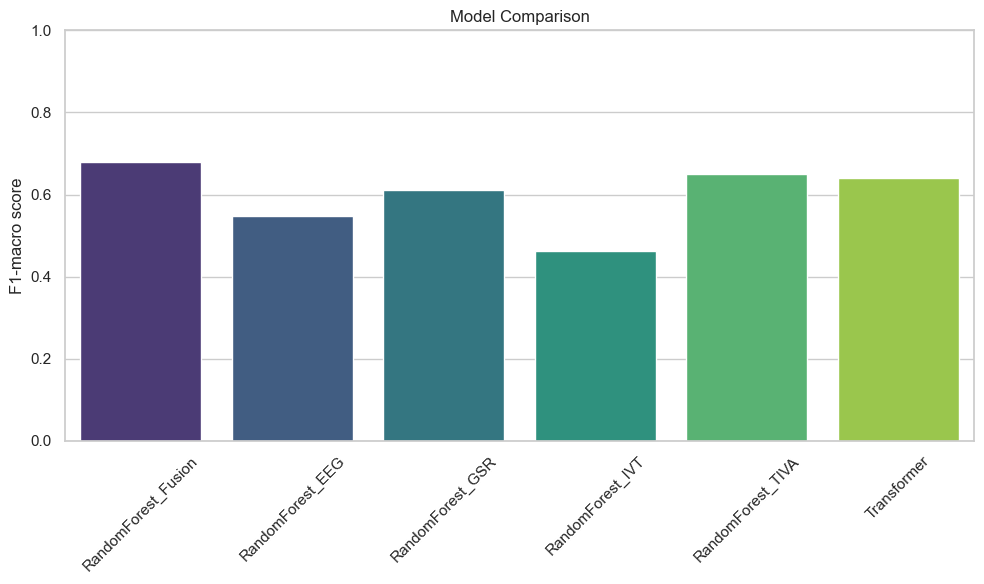

In [6]:
# Step 5: Plot comparison
plt.figure(figsize=(10,6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.ylabel("F1-macro score")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.tight_layout()
plt.show()